In [ ]:
# Imports & reproducibility
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)

import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import timm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
# Dataset preparation & splitting

DATA_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"  
SAVE_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl"
os.makedirs(SAVE_DIR, exist_ok=True)

IMAGE_SIZE = 224
SIMCLR_BS = 64
FINETUNE_BS = 32
SIMCLR_EPOCHS = 50
FINETUNE_EPOCHS = 50
PROJ_DIM = 128
SIMCLR_LR = 1e-3
FINETUNE_LR = 5e-5
TEMPERATURE = 0.5



In [3]:
import os

data_dir = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"
classes = os.listdir(data_dir)
for cls in classes:
    print(f"Class: {cls}, Number of Images: {len(os.listdir(os.path.join(data_dir, cls)))}")

Class: 1Gallstones, Number of Images: 1326
Class: 2Abdomen and retroperitoneum, Number of Images: 1170
Class: 3cholecystitis, Number of Images: 1146
Class: 4Membranous and gangrenous cholecystitis, Number of Images: 1224
Class: 5Perforation, Number of Images: 1062
Class: 6Polyps and cholesterol crystals, Number of Images: 1020
Class: 7Adenomyomatosis, Number of Images: 1164
Class: 8Carcinoma, Number of Images: 1590
Class: 9Various causes of gallbladder wall thickening, Number of Images: 990


In [ ]:
# build file lists and do stratified 80/10/10 split
root = Path(DATA_DIR)
assert root.exists(), f"{DATA_DIR} not found"

image_paths = []
image_labels = []
class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}

for cls in class_names:
    folder = root / cls
    for p in folder.glob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
            image_paths.append(str(p))
            image_labels.append(class_to_idx[cls])

print("Detected classes:", class_names)
print("Total images:", len(image_paths))
print("Per-class counts (original):", dict(Counter(image_labels)))

# Stratified 80% / 10% / 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels, test_size=0.20, stratify=image_labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print("Split sizes -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

# Print per-class distribution for each split
idx_to_class = {v:k for k,v in class_to_idx.items()}

def print_class_counts(labels, name):
    counts = Counter(labels)
    print(f"\n{name} set class distribution:")
    for cls_idx in sorted(counts.keys()):
        print(f"  {idx_to_class[cls_idx]} ({cls_idx}): {counts[cls_idx]}")
    print("Total:", sum(counts.values()))

print_class_counts(train_labels, "Train")
print_class_counts(val_labels, "Val")
print_class_counts(test_labels, "Test")


Detected classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening']
Total images: 10692
Per-class counts (original): {0: 1326, 1: 1170, 2: 1146, 3: 1224, 4: 1062, 5: 1020, 6: 1164, 7: 1590, 8: 990}
Split sizes -> train: 8553 val: 1069 test: 1070

Train set class distribution:
  1Gallstones (0): 1061
  2Abdomen and retroperitoneum (1): 936
  3cholecystitis (2): 917
  4Membranous and gangrenous cholecystitis (3): 979
  5Perforation (4): 849
  6Polyps and cholesterol crystals (5): 816
  7Adenomyomatosis (6): 931
  8Carcinoma (7): 1272
  9Various causes of gallbladder wall thickening (8): 792
Total: 8553

Val set class distribution:
  1Gallstones (0): 132
  2Abdomen and retroperitoneum (1): 117
  3cholecystitis (2): 115
  4Membranous and gangrenous cholecystitis (3): 122
  5Perforation (4): 107
  

In [ ]:
# Transforms & datasets

# SimCLR augmentations (two views)
simclr_transforms = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=int(0.1*IMAGE_SIZE)//2*2+1, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Fine-tuning transforms
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Datasets
class SimCLRDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Dataloaders
simclr_loader = DataLoader(SimCLRDataset(train_paths, simclr_transforms), batch_size=SIMCLR_BS, shuffle=True, drop_last=True)
train_loader = DataLoader(ImageDataset(train_paths, train_labels, train_transform), batch_size=FINETUNE_BS, shuffle=True)
val_loader = DataLoader(ImageDataset(val_paths, val_labels, eval_transform), batch_size=FINETUNE_BS, shuffle=False)
test_loader = DataLoader(ImageDataset(test_paths, test_labels, eval_transform), batch_size=FINETUNE_BS, shuffle=False)

print("SimCLR loader batches:", len(simclr_loader))
print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))


print("SimCLR dataset size:", len(SimCLRDataset(train_paths, simclr_transforms)), "batches:", len(simclr_loader))
print("Fine-tune train sizes:", len(ImageDataset(train_paths, train_labels, train_transform)), "\nFine-tune val sizes:", len(ImageDataset(val_paths, val_labels, eval_transform)), 
                                    "\nFine-tune test sizes:", len(ImageDataset(test_paths, test_labels, eval_transform)))


SimCLR loader batches: 133
Train batches: 268 Val batches: 34 Test batches: 34
SimCLR dataset size: 8553 batches: 133
Fine-tune train sizes: 8553 
Fine-tune val sizes: 1069 
Fine-tune test sizes: 1070


In [ ]:
# MobileViT-S Encoder + SimCLR Model + NT-Xent Loss

class MobileViTEncoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = timm.create_model("mobilevit_s", pretrained=pretrained, num_classes=0, global_pool="")
        self.out_dim = getattr(self.model, "num_features", None)
        if self.out_dim is None:
            raise RuntimeError("Cannot determine output dimension")
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        feat = self.model.forward_features(x)
        feat = self.pool(feat)
        feat = torch.flatten(feat, 1)
        return feat

class SimCLR(nn.Module):
    def __init__(self, encoder, proj_dim=128):
        super().__init__()
        self.encoder = encoder
        feat_dim = self.encoder.out_dim
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, proj_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        z = F.normalize(z, dim=1)
        return h, z

def nt_xent_loss(z_i, z_j, temperature=0.5, eps=1e-8):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim = torch.matmul(z, z.T) / temperature
    mask = ~torch.eye(2*batch_size, device=z.device).bool()
    exp_sim = torch.exp(sim) * mask.float()
    denom = exp_sim.sum(dim=1)
    pos = torch.exp((z_i * z_j).sum(dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log(pos / denom)
    return loss.mean()

# Instantiate model
encoder = MobileViTEncoder(pretrained=False)
simclr_model = SimCLR(encoder, proj_dim=PROJ_DIM).to(device)
print("SimCLR model ready. Encoder out_dim:", encoder.out_dim)


SimCLR model ready. Encoder out_dim: 640


SimCLR Epoch 1/50: 100%|██████████| 133/133 [09:07<00:00,  4.11s/it, loss=4.38]


SimCLR Epoch 1 completed. SimCLR Contrastive Loss: 4.381178


SimCLR Epoch 2/50: 100%|██████████| 133/133 [06:30<00:00,  2.93s/it, loss=4.29]


SimCLR Epoch 2 completed. SimCLR Contrastive Loss: 4.285401


SimCLR Epoch 3/50: 100%|██████████| 133/133 [06:30<00:00,  2.93s/it, loss=4.24]


SimCLR Epoch 3 completed. SimCLR Contrastive Loss: 4.241442


SimCLR Epoch 4/50: 100%|██████████| 133/133 [06:31<00:00,  2.94s/it, loss=4.14]


SimCLR Epoch 4 completed. SimCLR Contrastive Loss: 4.144171


SimCLR Epoch 5/50: 100%|██████████| 133/133 [06:30<00:00,  2.94s/it, loss=4.44]


SimCLR Epoch 5 completed. SimCLR Contrastive Loss: 4.439487


SimCLR Epoch 6/50: 100%|██████████| 133/133 [06:30<00:00,  2.94s/it, loss=4.41]


SimCLR Epoch 6 completed. SimCLR Contrastive Loss: 4.412722


SimCLR Epoch 7/50: 100%|██████████| 133/133 [06:30<00:00,  2.94s/it, loss=4.16]


SimCLR Epoch 7 completed. SimCLR Contrastive Loss: 4.159517


SimCLR Epoch 8/50: 100%|██████████| 133/133 [06:30<00:00,  2.94s/it, loss=4.12]


SimCLR Epoch 8 completed. SimCLR Contrastive Loss: 4.121901


SimCLR Epoch 9/50: 100%|██████████| 133/133 [06:30<00:00,  2.94s/it, loss=4.08]


SimCLR Epoch 9 completed. SimCLR Contrastive Loss: 4.081669


SimCLR Epoch 10/50: 100%|██████████| 133/133 [06:30<00:00,  2.93s/it, loss=4.06]


SimCLR Epoch 10 completed. SimCLR Contrastive Loss: 4.062252


SimCLR Epoch 11/50: 100%|██████████| 133/133 [06:29<00:00,  2.93s/it, loss=4.03]


SimCLR Epoch 11 completed. SimCLR Contrastive Loss: 4.031161


SimCLR Epoch 12/50: 100%|██████████| 133/133 [06:41<00:00,  3.02s/it, loss=3.99]


SimCLR Epoch 12 completed. SimCLR Contrastive Loss: 3.985604


SimCLR Epoch 13/50: 100%|██████████| 133/133 [06:43<00:00,  3.03s/it, loss=3.97]


SimCLR Epoch 13 completed. SimCLR Contrastive Loss: 3.967172


SimCLR Epoch 14/50: 100%|██████████| 133/133 [06:31<00:00,  2.94s/it, loss=3.95]


SimCLR Epoch 14 completed. SimCLR Contrastive Loss: 3.947855


SimCLR Epoch 15/50: 100%|██████████| 133/133 [06:31<00:00,  2.95s/it, loss=3.92]


SimCLR Epoch 15 completed. SimCLR Contrastive Loss: 3.916250


SimCLR Epoch 16/50: 100%|██████████| 133/133 [06:41<00:00,  3.02s/it, loss=3.92]


SimCLR Epoch 16 completed. SimCLR Contrastive Loss: 3.923561


SimCLR Epoch 17/50: 100%|██████████| 133/133 [13:33<00:00,  6.12s/it, loss=3.87]


SimCLR Epoch 17 completed. SimCLR Contrastive Loss: 3.871092


SimCLR Epoch 18/50: 100%|██████████| 133/133 [11:02<00:00,  4.98s/it, loss=3.86]


SimCLR Epoch 18 completed. SimCLR Contrastive Loss: 3.862491


SimCLR Epoch 19/50: 100%|██████████| 133/133 [07:01<00:00,  3.17s/it, loss=3.85]


SimCLR Epoch 19 completed. SimCLR Contrastive Loss: 3.850351


SimCLR Epoch 20/50: 100%|██████████| 133/133 [06:59<00:00,  3.16s/it, loss=3.83]


SimCLR Epoch 20 completed. SimCLR Contrastive Loss: 3.828210


SimCLR Epoch 21/50: 100%|██████████| 133/133 [07:00<00:00,  3.16s/it, loss=3.81]


SimCLR Epoch 21 completed. SimCLR Contrastive Loss: 3.814543


SimCLR Epoch 22/50: 100%|██████████| 133/133 [06:59<00:00,  3.16s/it, loss=3.79]


SimCLR Epoch 22 completed. SimCLR Contrastive Loss: 3.793198


SimCLR Epoch 23/50: 100%|██████████| 133/133 [07:03<00:00,  3.18s/it, loss=3.79]


SimCLR Epoch 23 completed. SimCLR Contrastive Loss: 3.786883


SimCLR Epoch 24/50: 100%|██████████| 133/133 [07:32<00:00,  3.40s/it, loss=3.77]


SimCLR Epoch 24 completed. SimCLR Contrastive Loss: 3.765747


SimCLR Epoch 25/50: 100%|██████████| 133/133 [07:17<00:00,  3.29s/it, loss=3.76]


SimCLR Epoch 25 completed. SimCLR Contrastive Loss: 3.762038


SimCLR Epoch 26/50: 100%|██████████| 133/133 [07:19<00:00,  3.30s/it, loss=3.74]


SimCLR Epoch 26 completed. SimCLR Contrastive Loss: 3.744693


SimCLR Epoch 27/50: 100%|██████████| 133/133 [07:18<00:00,  3.30s/it, loss=3.73]


SimCLR Epoch 27 completed. SimCLR Contrastive Loss: 3.727704


SimCLR Epoch 28/50: 100%|██████████| 133/133 [07:17<00:00,  3.29s/it, loss=3.72]


SimCLR Epoch 28 completed. SimCLR Contrastive Loss: 3.719742


SimCLR Epoch 29/50: 100%|██████████| 133/133 [07:17<00:00,  3.29s/it, loss=3.7] 


SimCLR Epoch 29 completed. SimCLR Contrastive Loss: 3.704480


SimCLR Epoch 30/50: 100%|██████████| 133/133 [07:18<00:00,  3.29s/it, loss=3.7] 


SimCLR Epoch 30 completed. SimCLR Contrastive Loss: 3.699718


SimCLR Epoch 31/50: 100%|██████████| 133/133 [07:17<00:00,  3.29s/it, loss=3.68]


SimCLR Epoch 31 completed. SimCLR Contrastive Loss: 3.681773


SimCLR Epoch 32/50: 100%|██████████| 133/133 [07:01<00:00,  3.17s/it, loss=3.68]


SimCLR Epoch 32 completed. SimCLR Contrastive Loss: 3.677518


SimCLR Epoch 33/50: 100%|██████████| 133/133 [07:02<00:00,  3.18s/it, loss=3.66]


SimCLR Epoch 33 completed. SimCLR Contrastive Loss: 3.657491


SimCLR Epoch 34/50: 100%|██████████| 133/133 [07:05<00:00,  3.20s/it, loss=3.65]


SimCLR Epoch 34 completed. SimCLR Contrastive Loss: 3.651591


SimCLR Epoch 35/50: 100%|██████████| 133/133 [07:01<00:00,  3.17s/it, loss=3.71]


SimCLR Epoch 35 completed. SimCLR Contrastive Loss: 3.713321


SimCLR Epoch 36/50: 100%|██████████| 133/133 [06:54<00:00,  3.12s/it, loss=3.77]


SimCLR Epoch 36 completed. SimCLR Contrastive Loss: 3.767395


SimCLR Epoch 37/50: 100%|██████████| 133/133 [06:59<00:00,  3.16s/it, loss=3.8] 


SimCLR Epoch 37 completed. SimCLR Contrastive Loss: 3.799487


SimCLR Epoch 38/50: 100%|██████████| 133/133 [07:00<00:00,  3.16s/it, loss=3.87]


SimCLR Epoch 38 completed. SimCLR Contrastive Loss: 3.867352


SimCLR Epoch 39/50: 100%|██████████| 133/133 [07:04<00:00,  3.19s/it, loss=3.8] 


SimCLR Epoch 39 completed. SimCLR Contrastive Loss: 3.800116


SimCLR Epoch 40/50: 100%|██████████| 133/133 [07:06<00:00,  3.21s/it, loss=3.8] 


SimCLR Epoch 40 completed. SimCLR Contrastive Loss: 3.795376


SimCLR Epoch 41/50: 100%|██████████| 133/133 [07:10<00:00,  3.23s/it, loss=3.77]


SimCLR Epoch 41 completed. SimCLR Contrastive Loss: 3.772637


SimCLR Epoch 42/50: 100%|██████████| 133/133 [07:11<00:00,  3.25s/it, loss=3.79]


SimCLR Epoch 42 completed. SimCLR Contrastive Loss: 3.786503


SimCLR Epoch 43/50: 100%|██████████| 133/133 [07:04<00:00,  3.20s/it, loss=3.94]


SimCLR Epoch 43 completed. SimCLR Contrastive Loss: 3.935701


SimCLR Epoch 44/50: 100%|██████████| 133/133 [07:05<00:00,  3.20s/it, loss=3.87]


SimCLR Epoch 44 completed. SimCLR Contrastive Loss: 3.865444


SimCLR Epoch 45/50: 100%|██████████| 133/133 [07:07<00:00,  3.21s/it, loss=3.89]


SimCLR Epoch 45 completed. SimCLR Contrastive Loss: 3.888745


SimCLR Epoch 46/50: 100%|██████████| 133/133 [06:59<00:00,  3.16s/it, loss=3.79]


SimCLR Epoch 46 completed. SimCLR Contrastive Loss: 3.787842


SimCLR Epoch 47/50: 100%|██████████| 133/133 [06:51<00:00,  3.10s/it, loss=3.73]


SimCLR Epoch 47 completed. SimCLR Contrastive Loss: 3.727211


SimCLR Epoch 48/50: 100%|██████████| 133/133 [06:51<00:00,  3.09s/it, loss=3.69]


SimCLR Epoch 48 completed. SimCLR Contrastive Loss: 3.690776


SimCLR Epoch 49/50: 100%|██████████| 133/133 [06:52<00:00,  3.10s/it, loss=3.68]


SimCLR Epoch 49 completed. SimCLR Contrastive Loss: 3.680649


SimCLR Epoch 50/50: 100%|██████████| 133/133 [06:51<00:00,  3.10s/it, loss=3.72]

SimCLR Epoch 50 completed. SimCLR Contrastive Loss: 3.722691
SimCLR weights saved to: C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\simclr_pretrain_weights.pth


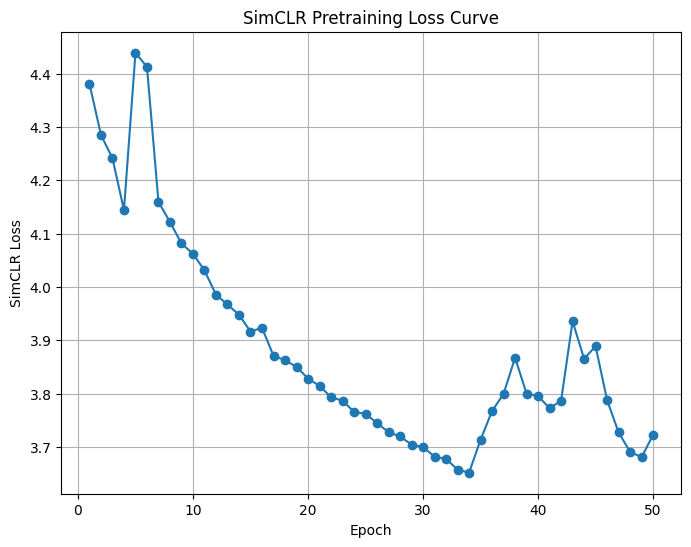

In [ ]:
# SimCLR Pretraining Loop (MobileViT-S, aligned loss calculation)
optimizer_simclr = torch.optim.AdamW(simclr_model.parameters(), lr=SIMCLR_LR, weight_decay=1e-4)
scheduler = None  
simclr_losses = []

simclr_pretrain_weights_path = os.path.join(SAVE_DIR, "simclr_pretrain_weights.pth")

for epoch in range(1, SIMCLR_EPOCHS+1):
    simclr_model.train()
    running_loss = 0.0
    pbar = tqdm(simclr_loader, desc=f"SimCLR Epoch {epoch}/{SIMCLR_EPOCHS}")

    for x1, x2 in pbar:
        x1, x2 = x1.to(device), x2.to(device)
        optimizer_simclr.zero_grad()

        # forward pass
        _, z1 = simclr_model(x1)
        _, z2 = simclr_model(x2)

        # NT-Xent loss
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        loss.backward()
        optimizer_simclr.step()

        # running loss
        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / len(simclr_loader))  

    epoch_loss = running_loss / len(simclr_loader)  # aligned with MobileViT-S
    simclr_losses.append(epoch_loss)
    print(f"SimCLR Epoch {epoch} completed. SimCLR Contrastive Loss: {epoch_loss:.6f}")

    #  Save checkpoint after each epoch (model + optimizer + epoch) 
    torch.save({
        'epoch': epoch,
        'simclr_state_dict': simclr_model.state_dict(),
        'optimizer_state_dict': optimizer_simclr.state_dict()
    }, simclr_pretrain_weights_path)

print(f"SimCLR weights saved to: {simclr_pretrain_weights_path}")

# Plot SimCLR loss curve
plt.figure(figsize=(8,6))
plt.plot(range(1, len(simclr_losses)+1), simclr_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SimCLR Loss")
plt.title("SimCLR Pretraining Loss Curve")
plt.grid(True)
plt.show()


In [ ]:
# Fine-tuning MobileViT-S

class FineTuneMobileViT(nn.Module):
    def __init__(self, simclr_model, num_classes):
        super().__init__()
        backbone = timm.create_model("mobilevit_s", pretrained=False, num_classes=0, global_pool="avg")
        # Load entire SimCLR encoder weights
        backbone.load_state_dict(simclr_model.encoder.model.state_dict())
        print("Loaded SimCLR encoder weights into MobileViT-S backbone.")
        self.backbone = backbone

        feat_dim = getattr(self.backbone, "num_features", simclr_model.encoder.out_dim)
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feat_dim),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim // 2, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        logits = self.classifier(feat)
        return logits

num_classes = len(classes)
finetune_model = FineTuneMobileViT(simclr_model, num_classes).to(device)


Loaded SimCLR encoder weights into MobileViT-S backbone.


In [ ]:
# Fine-tuning MobileViT-S Model

# Define optimizer: smaller LR for backbone, higher for classifier
optimizer_ft = torch.optim.AdamW([
    {'params': finetune_model.backbone.parameters(), 'lr': FINETUNE_LR / 5},
    {'params': finetune_model.classifier.parameters(), 'lr': FINETUNE_LR}
], weight_decay=1e-4)

criterion_ft = nn.CrossEntropyLoss()  # classification loss

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

finetune_weights_path = os.path.join(SAVE_DIR, "finetune_mobilevit_s.pth")

for epoch in range(1, FINETUNE_EPOCHS + 1):
    # Training
    finetune_model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    pbar = tqdm(train_loader, desc=f"Finetune Train Epoch {epoch}/{FINETUNE_EPOCHS}")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_ft.zero_grad()

        outputs = finetune_model(imgs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        # accumulate stats
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total += imgs.size(0)

        pbar.set_postfix(loss=running_loss / total, acc=running_corrects / total)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation
    finetune_model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion_ft(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total += imgs.size(0)

    epoch_val_loss = running_loss / total
    epoch_val_acc = running_corrects / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch}/{FINETUNE_EPOCHS} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Save best model 
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': finetune_model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'val_acc': best_val_acc
        }, finetune_weights_path)
        print(f"Saved best model (val_acc={best_val_acc:.4f}) -> {finetune_weights_path}")


Finetune Train Epoch 1/50: 100%|██████████| 268/268 [02:59<00:00,  1.50it/s, acc=0.296, loss=1.93]


Epoch 1/50 | Train Loss: 1.9335 | Train Acc: 0.2956 | Val Loss: 1.8068 | Val Acc: 0.3424
Saved best model (val_acc=0.3424) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 2/50: 100%|██████████| 268/268 [02:59<00:00,  1.49it/s, acc=0.383, loss=1.72]


Epoch 2/50 | Train Loss: 1.7210 | Train Acc: 0.3830 | Val Loss: 1.6890 | Val Acc: 0.4004
Saved best model (val_acc=0.4004) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 3/50: 100%|██████████| 268/268 [02:58<00:00,  1.50it/s, acc=0.425, loss=1.62]


Epoch 3/50 | Train Loss: 1.6167 | Train Acc: 0.4249 | Val Loss: 1.5960 | Val Acc: 0.4387
Saved best model (val_acc=0.4387) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 4/50: 100%|██████████| 268/268 [02:59<00:00,  1.50it/s, acc=0.464, loss=1.54]


Epoch 4/50 | Train Loss: 1.5383 | Train Acc: 0.4638 | Val Loss: 1.5244 | Val Acc: 0.4864
Saved best model (val_acc=0.4864) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 5/50: 100%|██████████| 268/268 [02:59<00:00,  1.50it/s, acc=0.49, loss=1.47] 


Epoch 5/50 | Train Loss: 1.4728 | Train Acc: 0.4904 | Val Loss: 1.4614 | Val Acc: 0.5061
Saved best model (val_acc=0.5061) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 6/50: 100%|██████████| 268/268 [02:57<00:00,  1.51it/s, acc=0.511, loss=1.42]


Epoch 6/50 | Train Loss: 1.4173 | Train Acc: 0.5112 | Val Loss: 1.3980 | Val Acc: 0.5341
Saved best model (val_acc=0.5341) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 7/50: 100%|██████████| 268/268 [02:57<00:00,  1.51it/s, acc=0.535, loss=1.37]


Epoch 7/50 | Train Loss: 1.3680 | Train Acc: 0.5348 | Val Loss: 1.3622 | Val Acc: 0.5360
Saved best model (val_acc=0.5360) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 8/50: 100%|██████████| 268/268 [03:02<00:00,  1.47it/s, acc=0.55, loss=1.33] 


Epoch 8/50 | Train Loss: 1.3254 | Train Acc: 0.5500 | Val Loss: 1.2968 | Val Acc: 0.5575
Saved best model (val_acc=0.5575) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 9/50: 100%|██████████| 268/268 [03:01<00:00,  1.47it/s, acc=0.572, loss=1.28]


Epoch 9/50 | Train Loss: 1.2812 | Train Acc: 0.5723 | Val Loss: 1.2583 | Val Acc: 0.5875
Saved best model (val_acc=0.5875) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 10/50: 100%|██████████| 268/268 [03:00<00:00,  1.48it/s, acc=0.58, loss=1.24] 


Epoch 10/50 | Train Loss: 1.2419 | Train Acc: 0.5801 | Val Loss: 1.2275 | Val Acc: 0.5921
Saved best model (val_acc=0.5921) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 11/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.597, loss=1.21]


Epoch 11/50 | Train Loss: 1.2070 | Train Acc: 0.5973 | Val Loss: 1.1858 | Val Acc: 0.6062
Saved best model (val_acc=0.6062) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 12/50: 100%|██████████| 268/268 [03:02<00:00,  1.47it/s, acc=0.611, loss=1.17]


Epoch 12/50 | Train Loss: 1.1656 | Train Acc: 0.6108 | Val Loss: 1.1514 | Val Acc: 0.6202
Saved best model (val_acc=0.6202) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 13/50: 100%|██████████| 268/268 [03:00<00:00,  1.48it/s, acc=0.622, loss=1.13]


Epoch 13/50 | Train Loss: 1.1332 | Train Acc: 0.6217 | Val Loss: 1.1315 | Val Acc: 0.6277
Saved best model (val_acc=0.6277) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 14/50: 100%|██████████| 268/268 [02:58<00:00,  1.50it/s, acc=0.633, loss=1.09]


Epoch 14/50 | Train Loss: 1.0937 | Train Acc: 0.6332 | Val Loss: 1.0876 | Val Acc: 0.6520
Saved best model (val_acc=0.6520) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 15/50: 100%|██████████| 268/268 [03:00<00:00,  1.49it/s, acc=0.651, loss=1.06]


Epoch 15/50 | Train Loss: 1.0650 | Train Acc: 0.6512 | Val Loss: 1.0574 | Val Acc: 0.6717
Saved best model (val_acc=0.6717) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 16/50: 100%|██████████| 268/268 [03:00<00:00,  1.48it/s, acc=0.661, loss=1.04]


Epoch 16/50 | Train Loss: 1.0410 | Train Acc: 0.6606 | Val Loss: 1.0365 | Val Acc: 0.6791
Saved best model (val_acc=0.6791) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 17/50: 100%|██████████| 268/268 [02:59<00:00,  1.50it/s, acc=0.664, loss=1.02]


Epoch 17/50 | Train Loss: 1.0223 | Train Acc: 0.6643 | Val Loss: 0.9941 | Val Acc: 0.6885
Saved best model (val_acc=0.6885) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 18/50: 100%|██████████| 268/268 [02:59<00:00,  1.49it/s, acc=0.679, loss=0.995]


Epoch 18/50 | Train Loss: 0.9955 | Train Acc: 0.6791 | Val Loss: 0.9751 | Val Acc: 0.6950
Saved best model (val_acc=0.6950) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 19/50: 100%|██████████| 268/268 [02:58<00:00,  1.50it/s, acc=0.687, loss=0.966]


Epoch 19/50 | Train Loss: 0.9659 | Train Acc: 0.6875 | Val Loss: 0.9454 | Val Acc: 0.7138
Saved best model (val_acc=0.7138) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 20/50: 100%|██████████| 268/268 [03:00<00:00,  1.49it/s, acc=0.698, loss=0.935]


Epoch 20/50 | Train Loss: 0.9354 | Train Acc: 0.6980 | Val Loss: 0.9181 | Val Acc: 0.7240
Saved best model (val_acc=0.7240) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 21/50: 100%|██████████| 268/268 [02:58<00:00,  1.50it/s, acc=0.705, loss=0.924]


Epoch 21/50 | Train Loss: 0.9237 | Train Acc: 0.7051 | Val Loss: 0.8912 | Val Acc: 0.7390
Saved best model (val_acc=0.7390) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 22/50: 100%|██████████| 268/268 [02:57<00:00,  1.51it/s, acc=0.71, loss=0.903] 


Epoch 22/50 | Train Loss: 0.9030 | Train Acc: 0.7102 | Val Loss: 0.8804 | Val Acc: 0.7334


Finetune Train Epoch 23/50: 100%|██████████| 268/268 [02:58<00:00,  1.50it/s, acc=0.722, loss=0.872]


Epoch 23/50 | Train Loss: 0.8723 | Train Acc: 0.7222 | Val Loss: 0.8515 | Val Acc: 0.7390


Finetune Train Epoch 24/50: 100%|██████████| 268/268 [03:23<00:00,  1.32it/s, acc=0.736, loss=0.847]


Epoch 24/50 | Train Loss: 0.8466 | Train Acc: 0.7361 | Val Loss: 0.8298 | Val Acc: 0.7540
Saved best model (val_acc=0.7540) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 25/50: 100%|██████████| 268/268 [03:10<00:00,  1.41it/s, acc=0.738, loss=0.832]


Epoch 25/50 | Train Loss: 0.8320 | Train Acc: 0.7379 | Val Loss: 0.8098 | Val Acc: 0.7596
Saved best model (val_acc=0.7596) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 26/50: 100%|██████████| 268/268 [03:05<00:00,  1.44it/s, acc=0.745, loss=0.81] 


Epoch 26/50 | Train Loss: 0.8098 | Train Acc: 0.7445 | Val Loss: 0.7910 | Val Acc: 0.7727
Saved best model (val_acc=0.7727) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 27/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.751, loss=0.794]


Epoch 27/50 | Train Loss: 0.7936 | Train Acc: 0.7512 | Val Loss: 0.7746 | Val Acc: 0.7736
Saved best model (val_acc=0.7736) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 28/50: 100%|██████████| 268/268 [03:05<00:00,  1.44it/s, acc=0.758, loss=0.771]


Epoch 28/50 | Train Loss: 0.7714 | Train Acc: 0.7583 | Val Loss: 0.7499 | Val Acc: 0.7914
Saved best model (val_acc=0.7914) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 29/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.765, loss=0.755]


Epoch 29/50 | Train Loss: 0.7554 | Train Acc: 0.7646 | Val Loss: 0.7304 | Val Acc: 0.7886


Finetune Train Epoch 30/50: 100%|██████████| 268/268 [03:05<00:00,  1.44it/s, acc=0.775, loss=0.736]


Epoch 30/50 | Train Loss: 0.7360 | Train Acc: 0.7750 | Val Loss: 0.7126 | Val Acc: 0.7914


Finetune Train Epoch 31/50: 100%|██████████| 268/268 [03:05<00:00,  1.44it/s, acc=0.779, loss=0.717]


Epoch 31/50 | Train Loss: 0.7171 | Train Acc: 0.7791 | Val Loss: 0.6930 | Val Acc: 0.8101
Saved best model (val_acc=0.8101) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 32/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.781, loss=0.705]


Epoch 32/50 | Train Loss: 0.7047 | Train Acc: 0.7805 | Val Loss: 0.6676 | Val Acc: 0.8092


Finetune Train Epoch 33/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.796, loss=0.678]


Epoch 33/50 | Train Loss: 0.6780 | Train Acc: 0.7956 | Val Loss: 0.6499 | Val Acc: 0.8157
Saved best model (val_acc=0.8157) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 34/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.799, loss=0.672]


Epoch 34/50 | Train Loss: 0.6716 | Train Acc: 0.7991 | Val Loss: 0.6406 | Val Acc: 0.8148


Finetune Train Epoch 35/50: 100%|██████████| 268/268 [03:03<00:00,  1.46it/s, acc=0.807, loss=0.643]


Epoch 35/50 | Train Loss: 0.6427 | Train Acc: 0.8074 | Val Loss: 0.6258 | Val Acc: 0.8241
Saved best model (val_acc=0.8241) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 36/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.812, loss=0.632]


Epoch 36/50 | Train Loss: 0.6315 | Train Acc: 0.8118 | Val Loss: 0.6156 | Val Acc: 0.8213


Finetune Train Epoch 37/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.813, loss=0.618]


Epoch 37/50 | Train Loss: 0.6183 | Train Acc: 0.8127 | Val Loss: 0.5816 | Val Acc: 0.8419
Saved best model (val_acc=0.8419) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 38/50: 100%|██████████| 268/268 [03:06<00:00,  1.44it/s, acc=0.815, loss=0.614]


Epoch 38/50 | Train Loss: 0.6143 | Train Acc: 0.8149 | Val Loss: 0.5912 | Val Acc: 0.8297


Finetune Train Epoch 39/50: 100%|██████████| 268/268 [03:06<00:00,  1.44it/s, acc=0.823, loss=0.594]


Epoch 39/50 | Train Loss: 0.5942 | Train Acc: 0.8231 | Val Loss: 0.5555 | Val Acc: 0.8391


Finetune Train Epoch 40/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.831, loss=0.573]


Epoch 40/50 | Train Loss: 0.5727 | Train Acc: 0.8314 | Val Loss: 0.5436 | Val Acc: 0.8531
Saved best model (val_acc=0.8531) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 41/50: 100%|██████████| 268/268 [03:04<00:00,  1.45it/s, acc=0.831, loss=0.562]


Epoch 41/50 | Train Loss: 0.5616 | Train Acc: 0.8306 | Val Loss: 0.5521 | Val Acc: 0.8428


Finetune Train Epoch 42/50: 100%|██████████| 268/268 [03:06<00:00,  1.44it/s, acc=0.837, loss=0.554]


Epoch 42/50 | Train Loss: 0.5539 | Train Acc: 0.8373 | Val Loss: 0.5297 | Val Acc: 0.8578
Saved best model (val_acc=0.8578) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 43/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.845, loss=0.532]


Epoch 43/50 | Train Loss: 0.5323 | Train Acc: 0.8447 | Val Loss: 0.5066 | Val Acc: 0.8522


Finetune Train Epoch 44/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.841, loss=0.536]


Epoch 44/50 | Train Loss: 0.5363 | Train Acc: 0.8413 | Val Loss: 0.4876 | Val Acc: 0.8728
Saved best model (val_acc=0.8728) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 45/50: 100%|██████████| 268/268 [03:06<00:00,  1.44it/s, acc=0.852, loss=0.505]


Epoch 45/50 | Train Loss: 0.5051 | Train Acc: 0.8523 | Val Loss: 0.4719 | Val Acc: 0.8709


Finetune Train Epoch 46/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.857, loss=0.498]


Epoch 46/50 | Train Loss: 0.4977 | Train Acc: 0.8571 | Val Loss: 0.4595 | Val Acc: 0.8700


Finetune Train Epoch 47/50: 100%|██████████| 268/268 [03:03<00:00,  1.46it/s, acc=0.857, loss=0.484]


Epoch 47/50 | Train Loss: 0.4839 | Train Acc: 0.8574 | Val Loss: 0.4480 | Val Acc: 0.8784
Saved best model (val_acc=0.8784) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 48/50: 100%|██████████| 268/268 [03:05<00:00,  1.45it/s, acc=0.863, loss=0.479]


Epoch 48/50 | Train Loss: 0.4786 | Train Acc: 0.8629 | Val Loss: 0.4362 | Val Acc: 0.8840
Saved best model (val_acc=0.8840) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 49/50: 100%|██████████| 268/268 [03:05<00:00,  1.44it/s, acc=0.869, loss=0.458]


Epoch 49/50 | Train Loss: 0.4582 | Train Acc: 0.8686 | Val Loss: 0.4148 | Val Acc: 0.8868
Saved best model (val_acc=0.8868) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_Mobilevit_S/outputs_simclr_ssl\finetune_mobilevit_s.pth


Finetune Train Epoch 50/50: 100%|██████████| 268/268 [03:06<00:00,  1.44it/s, acc=0.873, loss=0.448]


Epoch 50/50 | Train Loss: 0.4485 | Train Acc: 0.8731 | Val Loss: 0.4239 | Val Acc: 0.8812


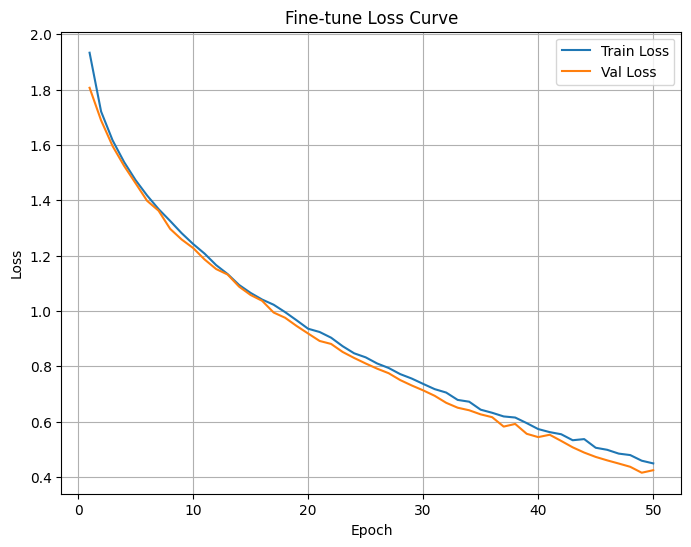

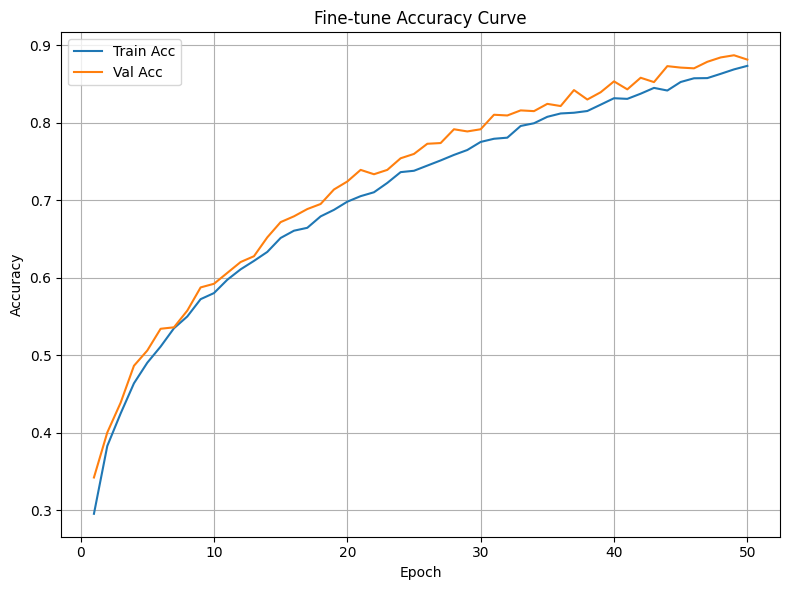

In [10]:
# Plot training curves
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.title("Fine-tune Loss Curve")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.title("Fine-tune Accuracy Curve")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()


Evaluating on test set: 100%|██████████| 34/34 [00:16<00:00,  2.01it/s]

Test metrics:
  Accuracy:  0.8850
  Precision (macro): 0.8880
  Recall (macro):    0.8850
  F1 (macro):        0.8856

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.91      0.86      0.89       133
                  2Abdomen and retroperitoneum       0.90      0.87      0.89       117
                                3cholecystitis       0.84      0.85      0.85       114
      4Membranous and gangrenous cholecystitis       0.90      0.98      0.94       123
                                  5Perforation       0.90      0.91      0.90       106
              6Polyps and cholesterol crystals       0.90      0.93      0.91       102
                              7Adenomyomatosis       0.88      0.90      0.89       117
                                    8Carcinoma       0.84      0.86      0.85       159
9Various causes of gallbladder wall thickening       

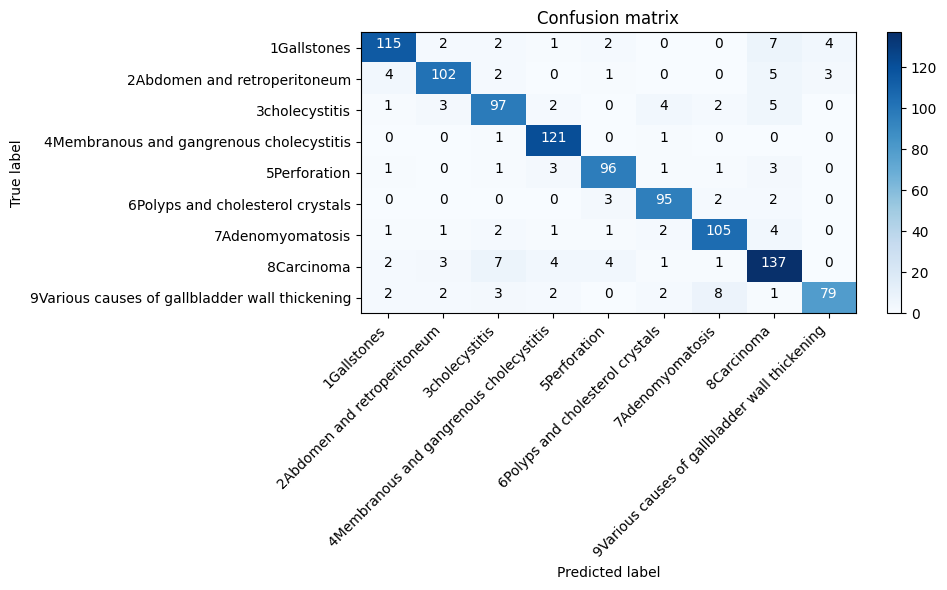

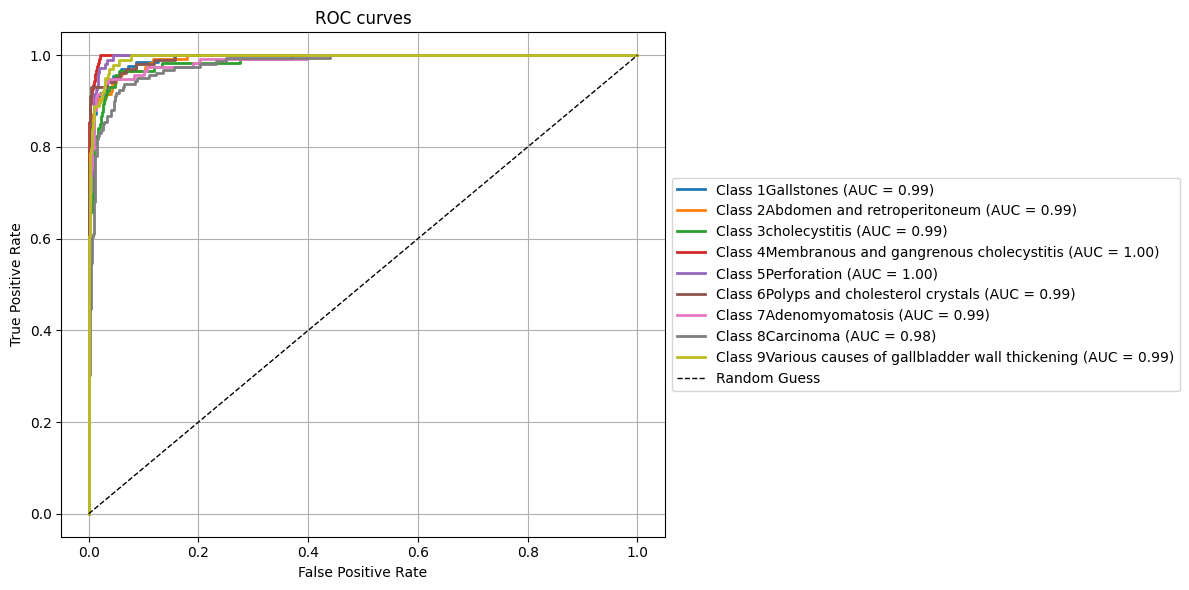

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights_path, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (macro): {precision_macro:.4f}")
print(f"  Recall (macro):    {recall_macro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Evaluating on test set: 100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


Test metrics:
  Accuracy:  0.8850
  Precision (weighted): 0.8857
  Recall (weighted):    0.8850
  F1 (weighted):        0.8846

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.91      0.86      0.89       133
                  2Abdomen and retroperitoneum       0.90      0.87      0.89       117
                                3cholecystitis       0.84      0.85      0.85       114
      4Membranous and gangrenous cholecystitis       0.90      0.98      0.94       123
                                  5Perforation       0.90      0.91      0.90       106
              6Polyps and cholesterol crystals       0.90      0.93      0.91       102
                              7Adenomyomatosis       0.88      0.90      0.89       117
                                    8Carcinoma       0.84      0.86      0.85       159
9Various causes of gallbladder wall thickeni

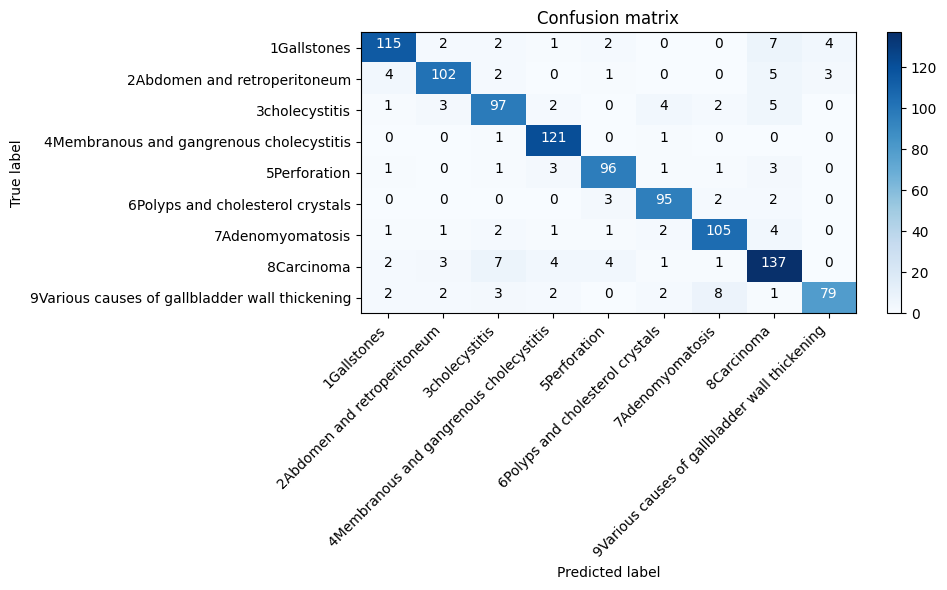

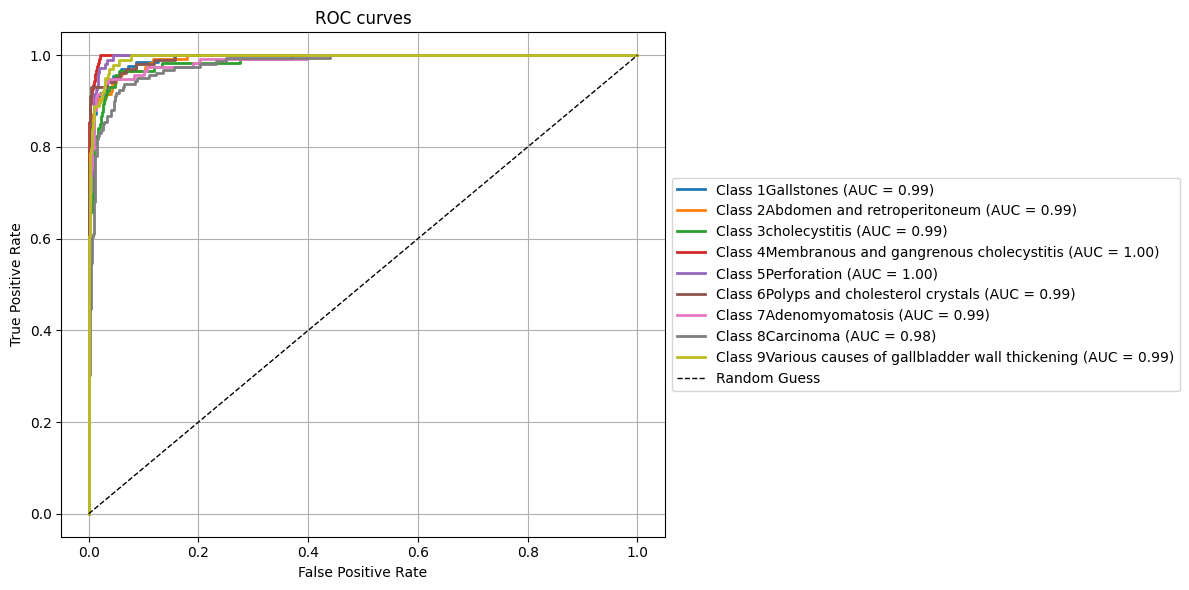

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights_path, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (weighted): {precision_macro:.4f}")
print(f"  Recall (weighted):    {recall_macro:.4f}")
print(f"  F1 (weighted):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.8647
  precision: 1.0000
  recall: 0.8647
  f1_score: 0.9274

Class: 2Abdomen and retroperitoneum
  accuracy: 0.8718
  precision: 1.0000
  recall: 0.8718
  f1_score: 0.9315

Class: 3cholecystitis
  accuracy: 0.8509
  precision: 1.0000
  recall: 0.8509
  f1_score: 0.9194

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 0.9837
  precision: 1.0000
  recall: 0.9837
  f1_score: 0.9918

Class: 5Perforation
  accuracy: 0.9057
  precision: 1.0000
  recall: 0.9057
  f1_score: 0.9505

Class: 6Polyps and cholesterol crystals
  accuracy: 0.9314
  precision: 1.0000
  recall: 0.9314
  f1_score: 0.9645

Class: 7Adenomyomatosis
  accuracy: 0.8974
  precision: 1.0000
  recall: 0.8974
  f1_score: 0.9459

Class: 8Carcinoma
  accuracy: 0.8616
  precision: 1.0000
  recall: 0.8616
  f1_score: 0.9257

Class: 9Various causes of gallbladder wall thickening
  accuracy: 0.7980
  precision: 1.0000
  recall: 0.7980
  f1_score: 0.8876



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.8647
  precision: 1.0000
  recall: 0.8647
  f1_score: 0.9274

Class: 2Abdomen and retroperitoneum
  accuracy: 0.8718
  precision: 1.0000
  recall: 0.8718
  f1_score: 0.9315

Class: 3cholecystitis
  accuracy: 0.8509
  precision: 1.0000
  recall: 0.8509
  f1_score: 0.9194

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 0.9837
  precision: 1.0000
  recall: 0.9837
  f1_score: 0.9918

Class: 5Perforation
  accuracy: 0.9057
  precision: 1.0000
  recall: 0.9057
  f1_score: 0.9505

Class: 6Polyps and cholesterol crystals
  accuracy: 0.9314
  precision: 1.0000
  recall: 0.9314
  f1_score: 0.9645

Class: 7Adenomyomatosis
  accuracy: 0.8974
  precision: 1.0000
  recall: 0.8974
  f1_score: 0.9459

Class: 8Carcinoma
  accuracy: 0.8616
  precision: 1.0000
  recall: 0.8616
  f1_score: 0.9257

Class: 9Various causes of gallbladder wall thickening
  accuracy: 0.7980
  precision: 1.0000
  recall: 0.7980
  f1_score: 0.8876

